In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
import string

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from tqdm._tqdm_notebook import tqdm_notebook

tqdm_notebook.pandas()

sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('../data/final_data_priority.csv')

In [3]:
df.isna().sum() / len(df) * 100

short_descriptions    1.620004
priority              1.608561
dtype: float64

In [4]:
df.dropna(inplace=True)

In [5]:
df.tail()

,short_descriptions,priority
166044,Data files per our call,4 - Low
166045,Approver Matrix,4 - Low
166046,a new Product Hierarchy Level 5 and 6: Vegeta...,4 - Low
166047,[SAP] Create SAP account in PROD for Charala...,4 - Low
166048,APO Daily and Monthly Chains to be triggere...,4 - Low


In [6]:
cnt_asgn_grps = df['priority'].value_counts()

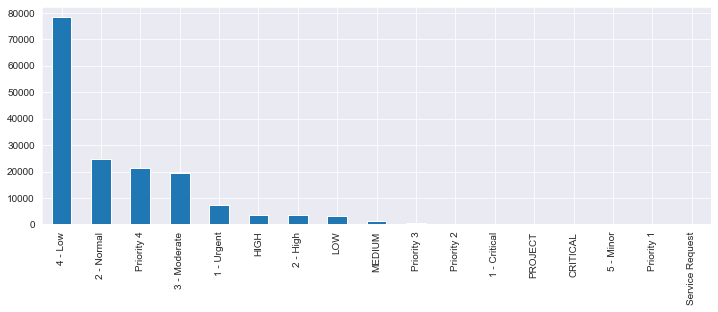

In [7]:
cnt_asgn_grps.plot(kind='bar', figsize=(12, 4))
plt.show()

In [8]:
np.unique(df['priority'])

array(['1 - Critical', '1 - Urgent', '2 - High', '2 - Normal',
       '3 - Moderate', '4 - Low', '5 - Minor', 'CRITICAL', 'HIGH', 'LOW',
       'MEDIUM', 'PROJECT', 'Priority 1', 'Priority 2', 'Priority 3',
       'Priority 4', 'Service Request'], dtype=object)

In [9]:
new_df = df.copy()

In [10]:
replacements = {
    '4 - Low': 'LOW',
    '5 - Minor': 'LOW',
    '3 - Moderate': 'MEDIUM',
    '2 - Normal': 'MEDIUM',
    'Priority 4': 'MEDIUM',
    'Priority 3': 'HIGH',
    'Priority 1': 'CRITICAL',
    'Priority 2': 'CRITICAL',
    '1 - Critical': 'CRITICAL',
    '1 - Urgent': 'CRITICAL',
    '2 - High': 'CRITICAL',
    'PROJECT': np.nan,
    'Service Request': np.nan
}

In [11]:
new_df = new_df.replace(
    {
        'priority': replacements
    }
)

In [12]:
new_df.isna().sum() / len(new_df) * 100

short_descriptions    0.00000
priority              0.05693
dtype: float64

In [13]:
new_df.dropna(inplace=True)

In [14]:
cnt_asgn_grps = new_df['priority'].value_counts()

In [15]:
cnt_asgn_grps

LOW         81388
MEDIUM      66454
CRITICAL    11413
HIGH         4011
Name: priority, dtype: int64

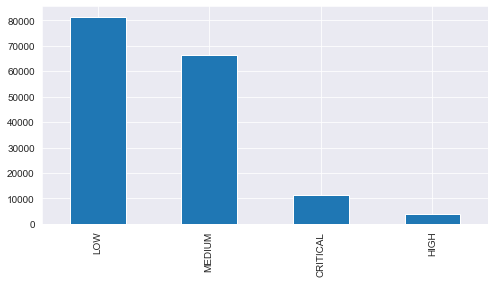

In [16]:
cnt_asgn_grps.plot(kind='bar', figsize=(8, 4))

plt.show()

In [17]:
X, y = new_df['short_descriptions'], new_df['priority']

In [18]:
def clean_text(text: str):
    text = text.lower()
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'  +', ' ', text)
    return text

In [19]:
X = X.progress_apply(lambda x: clean_text(x))

In [20]:
X[-5:]

166044                              data files per our call
166045                                     approver matrix 
166046     a new product hierarchy level and vegetable oil 
166047     sap create sap account in prod for charalampo...
166048     apo daily and monthly chains to be triggered ...
Name: short_descriptions, dtype: object

In [21]:
vectorizer = TfidfVectorizer() #HashingVectorizer(n_features=30000)
encoder = LabelEncoder()

over_sampler = SMOTE(random_state=0, n_jobs=-1)

In [22]:
X_vec = vectorizer.fit_transform(X)
y_enc = encoder.fit_transform(y)

In [23]:
X, y = over_sampler.fit_resample(X_vec, y_enc)

In [24]:
X = vectorizer.inverse_transform(X)
y = encoder.inverse_transform(y)

In [25]:
len(X), len(y)

(325552, 325552)

In [26]:
res_df = pd.DataFrame(
    {
        'short_descriptions': X,
        'priority': y
    }
)

In [27]:
res_df.tail()

,short_descriptions,priority
325547,"[for, office, telephone, conferencing]",MEDIUM
325548,"[missing, from, open, software, centre, won]",MEDIUM
325549,"[for, office, change, leave, maternity, licenc...",MEDIUM
325550,"[local, scanner, nun, nokia, detected, recon, ...",MEDIUM
325551,"[for, reset, in, system, initial, pwd]",MEDIUM


In [28]:
res_df['priority'].value_counts()

MEDIUM      81388
CRITICAL    81388
HIGH        81388
LOW         81388
Name: priority, dtype: int64

In [29]:
res_df.to_csv('../data/balanced_data.csv', index=False)

In [30]:
joblib.dump(value=vectorizer, filename='../models/vectorizer.pkl', compress=3)
joblib.dump(value=encoder, filename='../models/encoder.pkl', compress=3)

['../models/encoder.pkl']